In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import (
    MinMaxScaler,
    PowerTransformer,
    RobustScaler,
)


# classificador referência
from sklearn.dummy import DummyClassifier

# estudo lineares
from sklearn.linear_model import LogisticRegression

# estudo árvores
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from xgboost import plot_importance

# estudo SVM
from sklearn.svm import SVC

# estudo kNN
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from src.auxiliares import dataframe_coeficientes
from src.config import DADOS_TRATADOS
from src.graficos import plot_comparar_metricas_modelos, plot_coeficientes
from src.models_rus import RANDOM_STATE
from src.models_rus import (
    grid_search_cv_classificador,
    treinar_e_validar_modelo_classificacao,
    organiza_resultados,
)

sns.set_theme(palette="bright")

In [4]:
df = pd.read_parquet(DADOS_TRATADOS)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V19,V20,V21,V23,V24,V26,V27,V28,Amount,Class
0,25344.0,-0.995183,-0.039833,1.587280,-1.889184,0.086393,0.110665,0.371166,-0.181099,-1.065219,...,0.382649,-0.103440,0.053965,-0.090478,-0.286068,-0.476159,-0.405522,-0.155737,32.92,0
1,25344.0,-1.189360,1.156971,1.368210,-0.232449,-0.034136,-0.324731,0.401403,0.241093,-0.067642,...,-0.168669,0.196165,-0.209365,0.141775,0.171039,0.075594,0.366013,0.232066,0.89,0
2,25345.0,-1.603479,-0.275395,3.446021,3.525447,-0.959825,1.328505,-0.355322,0.293210,0.672573,...,1.252910,0.582112,-0.000287,-0.204721,0.486938,0.533273,0.421326,0.073160,185.09,0
3,25348.0,1.096714,-1.049339,-0.073346,-1.001950,0.084768,1.947188,-0.926699,0.628543,-0.716949,...,-0.133941,0.058939,0.123027,-0.038933,-1.871220,-0.142292,0.059422,-0.007457,79.71,0
4,25349.0,1.262724,0.292562,0.523730,0.614042,-0.429046,-0.978012,0.097620,-0.236076,-0.037052,...,-0.120721,-0.060064,-0.252002,0.130210,0.389602,0.093132,-0.025331,0.019989,0.89,0


In [5]:
coluna_min_max = ["Time"]

coluna_power_transformer = ["Amount"]

target = ["Class"]

colunas_robust_scaler = [
    coluna for coluna in df.columns if coluna not in (
        coluna_min_max + coluna_power_transformer + target
    )
]

colunas_robust_scaler

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V14',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V23',
 'V24',
 'V26',
 'V27',
 'V28']

In [6]:
X = df.drop(columns=target)
y = df[target].values.ravel()

In [7]:
preprocessamento = ColumnTransformer(
    transformers=[
        ("min_max", MinMaxScaler(), coluna_min_max),
        ("robust", RobustScaler(), colunas_robust_scaler),
        ("power_transform", PowerTransformer(), coluna_power_transformer),
    ]
)

In [8]:
# scale_pos_weight = np.bincount(y)[0] / np.bincount(y)[1]
# scale_pos_weight

In [11]:
classificadores = {
    "DummyClassifier": {
        "preprocessor": None,
        "classificador": DummyClassifier(strategy="stratified"),
    },
    "LogisticRegression": {
        "preprocessor": preprocessamento,
        "classificador": LogisticRegression(class_weight="balanced"),
    },
    "DecisionTreeClassifier": {
        "preprocessor": None,
        "classificador": DecisionTreeClassifier(class_weight="balanced"),
    },
    "LGBMClassifier": {
        "preprocessor": None,
        "classificador": LGBMClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=-1,
            #scale_pos_weight=scale_pos_weight,
        ),
    },
    "XGBClassifier": {
        "preprocessor": None,
        "classificador": XGBClassifier(
            random_state=RANDOM_STATE, n_jobs=-1
        ),
    },
     "SVC": {
         "preprocessor": preprocessamento,
         "classificador": SVC(class_weight="balanced", cache_size=1000),
     },
    "KNeighborsClassifier": {
        "preprocessor": preprocessamento,
        "classificador": KNeighborsClassifier(),
    },
}

In [12]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [13]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_classificacao(X, y, kf, **classificador)
    for nome_modelo, classificador in classificadores.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
0,DummyClassifier,0.326043,0.298233,0.496538,0.447343,0.003012,0.001512,0.397959,0.468269,0.001805,0.624276
1,DummyClassifier,0.90289,0.605586,0.501628,0.485539,0.003587,0.001801,0.469388,0.511694,0.001958,1.508476
2,DummyClassifier,0.533842,0.459921,0.501102,0.500552,0.003816,0.001915,0.5,0.525681,0.002019,0.993763
3,DummyClassifier,0.389232,0.478785,0.499386,0.497172,0.003803,0.001909,0.494949,0.497103,0.00192,0.868018
4,DummyClassifier,0.218436,0.535754,0.501199,0.548488,0.004593,0.002305,0.59596,0.510692,0.001974,0.75419
5,LogisticRegression,3.184682,0.416764,0.971331,0.970361,0.114458,0.060819,0.969388,0.9958,0.670183,3.601445
6,LogisticRegression,3.319746,0.407956,0.965227,0.93675,0.09077,0.047772,0.908163,0.985933,0.677877,3.727702
7,LogisticRegression,3.847314,0.5312,0.967801,0.938039,0.097321,0.051415,0.908163,0.968049,0.464583,4.378513
8,LogisticRegression,5.664488,1.344407,0.97646,0.9378,0.12852,0.069207,0.89899,0.974211,0.752926,7.008895
9,LogisticRegression,6.721972,0.974158,0.972462,0.940838,0.113065,0.060281,0.909091,0.972648,0.778141,7.69613


In [15]:
df_resultados.groupby("model").mean().sort_values("test_average_precision")

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
model,,,,,,,,,,
DummyClassifier,0.474089,0.475656,0.499971,0.495819,0.003762,0.001888,0.491651,0.502688,0.001935,0.949745
DecisionTreeClassifier,0.756271,0.466906,0.904296,0.902368,0.034948,0.017821,0.900433,0.902368,0.016232,1.223177
KNeighborsClassifier,2.029211,9.188273,0.972509,0.93652,0.111742,0.059574,0.900392,0.969675,0.312967,11.217485
LogisticRegression,4.54764,0.734897,0.970656,0.944758,0.108827,0.057899,0.918759,0.979328,0.668742,5.282537
SVC,3.584441,10.737251,0.982639,0.927408,0.162093,0.089404,0.871965,0.981383,0.715941,14.321691
XGBClassifier,0.296889,0.36817,0.96903,0.940908,0.102576,0.054382,0.912678,0.98023,0.779237,0.665058
LGBMClassifier,10.80807,1.613374,0.973242,0.94199,0.116262,0.062134,0.910616,0.981543,0.780737,12.421445


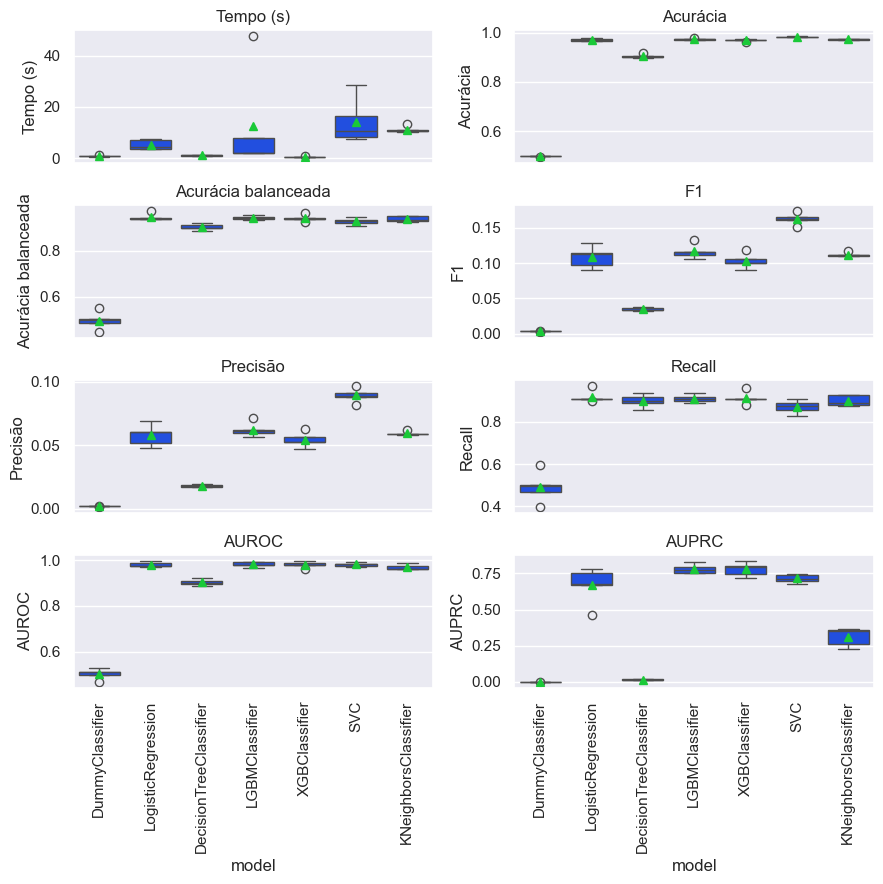

In [16]:
plot_comparar_metricas_modelos(df_resultados)

In [17]:
treinar_e_validar_modelo_classificacao(
    X, y, kf, **classificadores["XGBClassifier"]
)

{'fit_time': array([0.7764976 , 0.4347899 , 0.32658482, 0.2942965 , 0.24872351]),
 'score_time': array([0.35231757, 0.34376192, 0.45279193, 0.42084312, 0.40465689]),
 'test_accuracy': array([0.96302292, 0.96852267, 0.97408094, 0.97131156, 0.96821063]),
 'test_balanced_accuracy': array([0.96110697, 0.93840076, 0.94118521, 0.92513921, 0.93870795]),
 'test_f1': array([0.09021113, 0.09933036, 0.11811546, 0.10577508, 0.09944751]),
 'test_precision': array([0.04733132, 0.05253837, 0.06316537, 0.05627426, 0.05260082]),
 'test_recall': array([0.95918367, 0.90816327, 0.90816327, 0.87878788, 0.90909091]),
 'test_roc_auc': array([0.99508459, 0.98755051, 0.97811517, 0.9613923 , 0.97900649]),
 'test_average_precision': array([0.83486986, 0.74506427, 0.7174885 , 0.80374366, 0.79501947])}

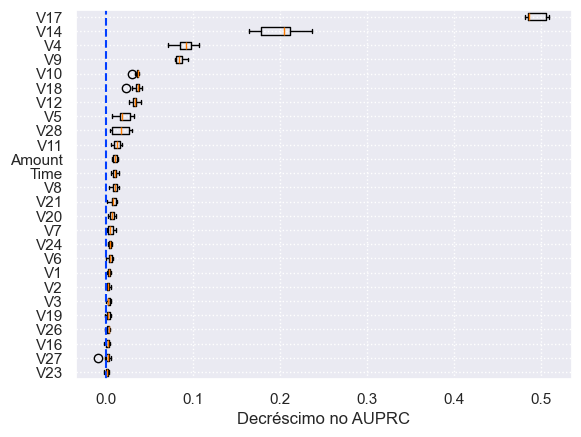

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=RANDOM_STATE, stratify=y
)

clf = classificadores["XGBClassifier"]["classificador"]

clf.fit(X_train, y_train)

perm_imp = permutation_importance(
    clf,
    X_test,
    y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring="average_precision",
)

fig, ax = plt.subplots()

ordem = perm_imp.importances_mean.argsort()

ax.boxplot(perm_imp.importances[ordem].T, vert=False, tick_labels=X.columns[ordem])
ax.axvline(x=0, linestyle="--")
ax.set_xlabel("Decréscimo no AUPRC")
ax.grid(True, linestyle=":")

plt.show()

In [19]:
perm_imp.importances_mean

array([0.01050143, 0.00412979, 0.00359688, 0.0033669 , 0.09184075,
       0.02118771, 0.00471889, 0.00570919, 0.01021623, 0.08488923,
       0.03611943, 0.0134752 , 0.03348915, 0.19823961, 0.00192358,
       0.49352214, 0.0355572 , 0.00314097, 0.00712852, 0.00878718,
       0.00137521, 0.00546474, 0.00281211, 0.00155243, 0.01739748,
       0.0107974 ])

In [20]:
X.columns[perm_imp.importances_mean < 0.01]

Index(['V1', 'V2', 'V3', 'V6', 'V7', 'V16', 'V19', 'V20', 'V21', 'V23', 'V24',
       'V26', 'V27'],
      dtype='object')

In [21]:
X = X.drop(columns=X.columns[perm_imp.importances_mean < 0.01])

X.columns

Index(['Time', 'V4', 'V5', 'V8', 'V9', 'V10', 'V11', 'V12', 'V14', 'V17',
       'V18', 'V28', 'Amount'],
      dtype='object')

In [22]:
treinar_e_validar_modelo_classificacao(
    X, y, kf, **classificadores["XGBClassifier"]
)

{'fit_time': array([0.37790346, 0.19290471, 0.21294689, 0.17556453, 0.23603415]),
 'score_time': array([0.37453866, 0.41789985, 0.39030671, 0.40296483, 0.37379479]),
 'test_accuracy': array([0.95736714, 0.96417357, 0.96840566, 0.96456363, 0.9650707 ]),
 'test_balanced_accuracy': array([0.95827367, 0.93112978, 0.93324987, 0.92175872, 0.93209421]),
 'test_f1': array([0.07919124, 0.08743169, 0.09799555, 0.08739327, 0.09040122]),
 'test_precision': array([0.04130053, 0.045953  , 0.05182568, 0.04598309, 0.04759358]),
 'test_recall': array([0.95918367, 0.89795918, 0.89795918, 0.87878788, 0.8989899 ]),
 'test_roc_auc': array([0.99477454, 0.9861213 , 0.97935995, 0.96470469, 0.97759347]),
 'test_average_precision': array([0.84063412, 0.77490187, 0.73261222, 0.77902435, 0.80199256])}

In [23]:
param_grid = {
    "clf__max_depth": [3, 6, 10],  # Profundidade da árvore
    # "clf__min_child_weight": [1, 3, 5],  # Peso mínimo de uma folha
    # "clf__gamma": [0, 0.1, 0.3],  # Redução mínima de perda para uma divisão
    "clf__subsample": [0.6, 0.8, 1.0],  # Proporção de amostras usadas para cada árvore
    "clf__colsample_bytree": [0.6, 0.8, 1.0],  # Proporção de features para cada árvore
    # "clf__learning_rate": [0.1, 0.3, 0.5],  # Taxa de aprendizado
    # "clf__n_estimators": [10, 50, 100],  # Número de árvores
    "clf__reg_lambda": [1, 2, 5],  # Regularização L2
    "clf__reg_alpha": [0, 0.5, 1],  # Regularização L1
    # "clf__scale_pos_weight": [1, scale_pos_weight],  # Peso das classes
}

In [25]:
clf = XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1)

grid_search = grid_search_cv_classificador(
    clf, param_grid, kf, None, refit_metric="average_precision"
)

grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('sampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_me...
                                                      n_estimators=None,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'clf__colsample_bytree': [0.6, 0.8, 1.0],
                         'clf__max_depth': [3, 6, 10],
                         'clf__reg_alpha': [0, 0.5, 1],
                         'clf__reg_lambda': [1, 2, 5],
                         'clf__subsample': [0.6, 0.8, 1.0]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [27]:
grid_search.fit(X, y)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('sampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('clf',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_me...
                                                      n_estimators=None,
                                                      n_jobs=-1,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'clf__colsample_bytree': [0.6, 0.8, 1.0],
                         'clf__max_depth': [3, 6, 10],
                         'clf__reg_alpha': [0, 0.5, 1],
                         'clf__reg_lambda': [1, 2, 5],
                         'clf__subsample': [0.6, 0.8, 1.0]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [28]:
grid_search.best_params_

{'clf__colsample_bytree': 0.8,
 'clf__max_depth': 6,
 'clf__reg_alpha': 1,
 'clf__reg_lambda': 2,
 'clf__subsample': 1.0}

In [29]:
grid_search.best_score_

0.7993458289523512

In [30]:
grid_search.best_estimator_

Pipeline(steps=[('sampler', RandomUnderSampler(random_state=42)),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [32]:
colunas_test = [coluna for coluna in df_resultados.columns if coluna.startswith("test")]
colunas_test_mean = ["mean_" + coluna for coluna in colunas_test]
colunas_test_mean

['mean_test_accuracy',
 'mean_test_balanced_accuracy',
 'mean_test_f1',
 'mean_test_precision',
 'mean_test_recall',
 'mean_test_roc_auc',
 'mean_test_average_precision']

In [36]:
for coluna in colunas_test_mean:
    print(f"{coluna}: {grid_search.cv_results_[coluna][grid_search.best_index_]}")

mean_test_accuracy: 0.9676879570941004
mean_test_balanced_accuracy: 0.9412543020206829
mean_test_f1: 0.09912490298128647
mean_test_precision: 0.05244323709365557
mean_test_recall: 0.9147186147186147
mean_test_roc_auc: 0.9802481793718034
mean_test_average_precision: 0.7993458289523512


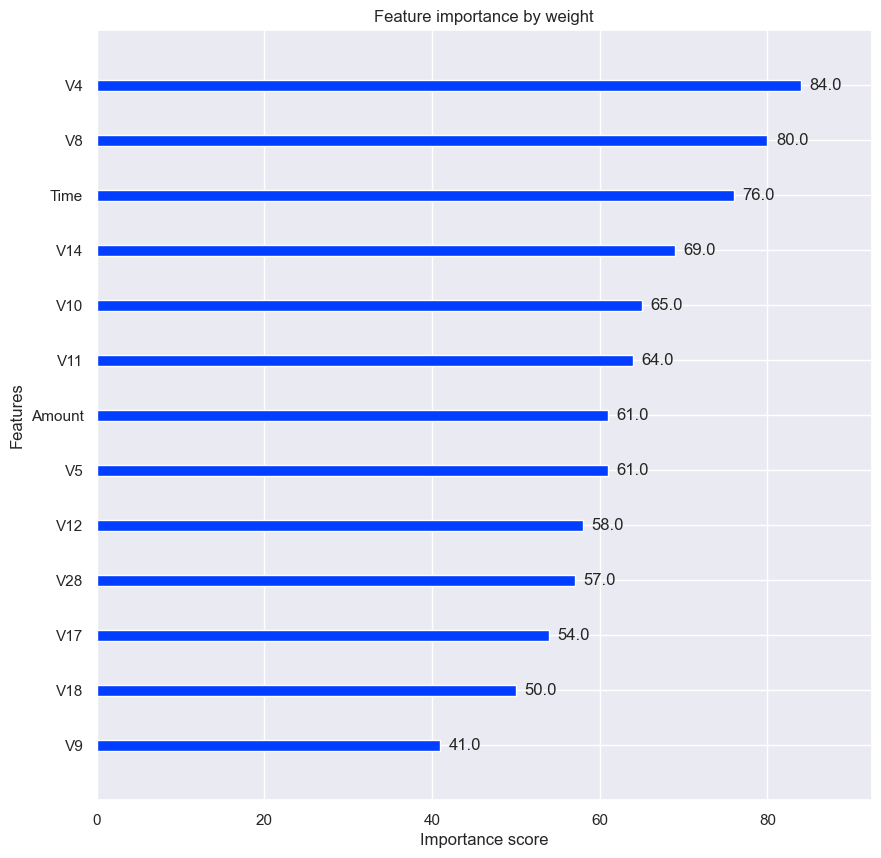

In [40]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_importance(
    grid_search.best_estimator_["clf"],
    ax=ax,
    importance_type="weight",
    title="Feature importance by weight"
)

plt.show()

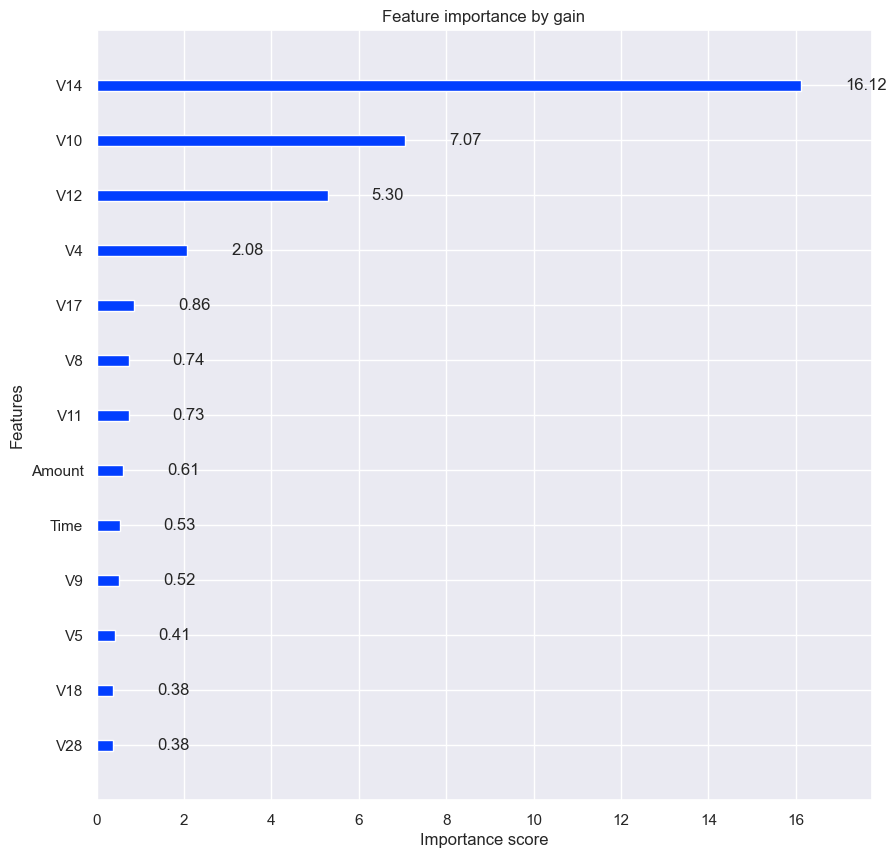

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))

plot_importance(
    grid_search.best_estimator_["clf"],
    ax=ax,
    importance_type="gain",
    title="Feature importance by gain",
    values_format="{v:.2f}"
)

plt.show()